In [1]:
import os
import sys
import xarray as xr
import numpy as np
import matplotlib
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
from pathlib import Path
import cartopy.crs as ccrs
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
TC_dir = Path('/neelin2020/TempestExtremes/TC')

In [4]:
%%time
TC_file = open(TC_dir / 'ERA5_TC_tracks_20200824.txt', mode='r')
var_list = ['x grid point of the centre','y grid point of the centre','longitude','latitude',
           'slp','Pressure drop','Maximum Surface Wind','year','month','day','hour']
df_list = []
with open(TC_dir / 'ERA5_TC_tracks_20200824.txt', 'r') as f:
    
    lines = f.readlines()
    
    for n,line in enumerate(lines):

        line_current = line.split()
        if n <= (len(lines)-2): # (n-1) n means total line number
            line_next = lines[n+1].split()

        if line_current[0] == 'start': # if a new track starts, showing a header info only
            df_track = pd.DataFrame() # reset dataframe for a new track
            
        else:  # expanding the info of the current track
            tmp = pd.DataFrame(data=np.asarray(line_current).reshape(1,11), columns=var_list)
            df_track = pd.concat([df_track, tmp])

        # end of current track
        if line_next[0] == 'start': 
            
            # save df_track into the list as a xarray.dataset
            timestamp_list = []
            lon_list = []
            lat_list = []
            sp_list = []
            for t in range(len(df_track['year'])):
                year = int(df_track.iloc[t].year)
                month = int(df_track.iloc[t].month)
                day = int(df_track.iloc[t].day)
                hour = int(df_track.iloc[t].hour)
                timestamp = datetime(year, month, day, hour)
                timestamp_list.append(timestamp)
                
                lon_list.append(float(df_track.iloc[t].longitude))
                lat_list.append(float(df_track.iloc[t].latitude))
                sp_list.append(float(df_track.iloc[t].slp))
            
            # create xarray.dataset
            ds = xr.Dataset(data_vars = dict(
                            meanlon = (['time'], lon_list),
                            meanlat = (['time'], lat_list),
                            slp = (['time'], sp_list),
                            base_time = (['time'], timestamp_list)),
                           
                            coords= dict(time = (['time'], range(len(timestamp_list)))),
                            attrs = dict(description='TempestExtreme TC'))
            
            df_list.append(ds)

        # for the last track
        if n == (len(lines)-1): # the last line
            
            # save df_track into the list as a xarray.dataset
            timestamp_list = []
            lon_list = []
            lat_list = []
            sp_list = []
            for t in range(len(df_track['year'])):
                year = int(df_track.iloc[t].year)
                month = int(df_track.iloc[t].month)
                day = int(df_track.iloc[t].day)
                hour = int(df_track.iloc[t].hour)
                timestamp = datetime(year, month, day, hour)
                timestamp_list.append(timestamp)
                
                lon_list.append(float(df_track.iloc[t].longitude))
                lat_list.append(float(df_track.iloc[t].latitude))
                sp_list.append(float(df_track.iloc[t].slp))                
            
            # create xarray.dataset
            ds = xr.Dataset(data_vars = dict(
                            meanlon = (['time'], lon_list),
                            meanlat = (['time'], lat_list),
                            slp = (['time'], sp_list),
                            base_time = (['time'], timestamp_list)),
                           
                            coords= dict(time = (['time'], range(len(timestamp_list)))),
                            attrs = dict(description='TempestExtreme TC tracks',
                                         frequency='6 hourly',
                                         source='ERA5, 0.25-deg.',
                                         ))
            
            df_list.append(ds)

CPU times: user 39.9 s, sys: 65.7 ms, total: 40 s
Wall time: 40.1 s


In [5]:
# merge all tracks into a single xarray.dataset file 
ds_TC = xr.concat(df_list, dim=pd.Index(np.arange(len(df_list)), name='tracks'))

In [6]:
# extract 2000-2020 to match existing EAR5 data
idx_year = np.asarray([str(i)[:4] for i in ds_TC.base_time.isel(time=0).values], dtype='int')
idx_select = np.where(np.logical_and(idx_year >= 2001, idx_year <= 2020))[0]
ds_TC_20yr = ds_TC.isel(tracks=idx_select)

In [7]:
ds_TC_20yr.to_netcdf('/neelin2020/TempestExtremes/TC/ERA5_TC_tracks_2001_2020.nc'
                     , encoding={'meanlon': {'dtype': 'float32'}, 'meanlat': {'dtype': 'float32'}})

In [9]:
ds_TC_20yr

<xarray.Dataset> Size: 5MB
Dimensions:    (tracks: 1548, time: 107)
Coordinates:
  * time       (time) int64 856B 0 1 2 3 4 5 6 7 ... 100 101 102 103 104 105 106
  * tracks     (tracks) int64 12kB 1543 1544 1545 1546 ... 3087 3088 3089 3090
Data variables:
    meanlon    (tracks, time) float64 1MB 94.25 90.25 87.0 84.5 ... nan nan nan
    meanlat    (tracks, time) float64 1MB -7.75 -9.0 -9.25 -9.75 ... nan nan nan
    slp        (tracks, time) float64 1MB 1.006e+05 1.006e+05 ... nan nan
    base_time  (tracks, time) datetime64[ns] 1MB 2001-01-02T06:00:00 ... NaT
Attributes:
    description:  TempestExtreme TC

In [8]:
# 2014 TCs
idx_select = np.where(idx_year == 2014)[0]
ds_TC_2014 = ds_TC.isel(tracks=idx_select)

In [16]:
%%time
# remove redundant NaT because of 20-year data
ds_list = []
for n in range(len(ds_TC_2014.tracks)):
    
    tmp = ds_TC_2014.isel(tracks=n).base_time.values
    idt_length = len(np.where(~np.isnat(tmp))[0])
    ds_list.append(ds_TC_2014.isel(tracks=n, time=slice(0,idt_length)))
ds_TC_2014_reduce = xr.concat(ds_list, dim='tracks')    

CPU times: user 175 ms, sys: 1.88 ms, total: 177 ms
Wall time: 174 ms


In [20]:
ds_TC_2014_reduce.to_netcdf('/neelin2020/TempestExtremes/TC/ERA5_TC_tracks_2014.nc'
                     , encoding={'meanlon': {'dtype': 'float32'}, 'meanlat': {'dtype': 'float32'}})

In [30]:
%%time
test = xr.open_dataset('/scratch/wmtsai/featenv_test/dataset/TC_TempestExtremes/2014/environment_catalogs/VARS_2D/TC_TempestExtremes_precipitation.merged.nc')

CPU times: user 23.1 ms, sys: 63.4 ms, total: 86.5 ms
Wall time: 105 ms


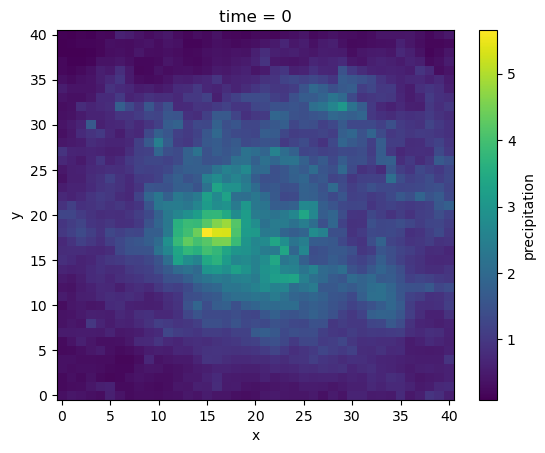

In [38]:
test.isel(time=0).mean('tracks').precipitation.plot()

In [32]:
%%time
test_compress = xr.open_dataset('/scratch/wmtsai/featenv_test/dataset/TC_TempestExtremes/2014/environment_catalogs/VARS_2D/TC_TempestExtremes_precipitation.merged.L4.nc')

CPU times: user 22 ms, sys: 3.18 ms, total: 25.2 ms
Wall time: 22 ms


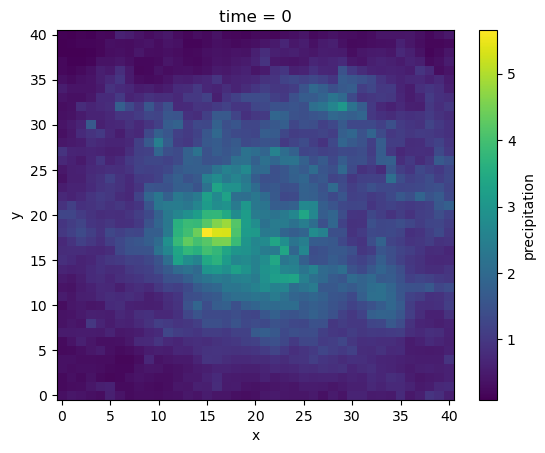

In [39]:
test_compress.isel(time=0).mean('tracks').precipitation.plot()